In [94]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
import src.vectorizer as vectorizer
import src.preprocessing as preprocessing
import re
from textstat.textstat import textstat
from textblob import TextBlob
import seaborn as sns
import string
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
%matplotlib inline

In [2]:
text_only_df = pd.read_csv('data/labels_and_text_only.csv', index_col=0)


In [3]:
def remove_handles(content):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",content).split())

def count_handles(content):
    return len(re.findall("(@[A-Za-z0-9]+)",content))

def bool_handles(content):
    match = re.search("(@[A-Za-z0-9]+)", content)
    if match:
        return 1
    else: return 0

def count_hashtags(content):
    return len(re.findall("(#[A-Za-z0-9]+)",content))

def bool_hashtags(content):
    match = re.search("(#[A-Za-z0-9]+)", content)
    if match:
        return 1
    else: return 0

def is_retweet(content):
    return int("RT " in content)

def has_url(content):
    return int("https://" in content or "http://" in content)

def build_POS_list(content):
    content = content.decode('latin-1')
    return ' '.join([item[1] for item in pos_tag(word_tokenize(content))])



In [4]:
text_only_df['tweet_no_handle'] = text_only_df['tweet_text'].apply(remove_handles)

## Adding Reading Scores

In [5]:
text_only_df['reading_ease'] = text_only_df['tweet_no_handle'].apply(textstat.flesch_reading_ease)
text_only_df['reading_grade'] = text_only_df['tweet_no_handle'].apply(textstat.flesch_kincaid_grade)

## Adding Sentiment Analysis

In [6]:
text_only_df['sentiment'] = text_only_df['tweet_no_handle'].map(lambda x: TextBlob(x.decode('latin-1')).polarity)
text_only_df['subjectivity'] = text_only_df['tweet_no_handle'].map(lambda x: TextBlob(x.decode('latin-1')).subjectivity)

## Add More Features

In [7]:
text_only_df['mentions_count'] = text_only_df['tweet_text'].apply(count_handles)
text_only_df['mentions_bool'] = text_only_df['tweet_text'].apply(bool_handles)
text_only_df['hashtag_count'] = text_only_df['tweet_text'].apply(count_hashtags)
text_only_df['hashtag_bool'] = text_only_df['tweet_text'].apply(bool_hashtags)
text_only_df['has_url'] = text_only_df['tweet_text'].apply(is_retweet)
text_only_df['tweet_length'] = text_only_df['tweet_no_handle'].apply(len)
text_only_df['word_count'] = text_only_df['tweet_no_handle'].apply(textstat.lexicon_count)
text_only_df['syllable_count'] = text_only_df['tweet_no_handle'].apply(textstat.syllable_count)

In [8]:
text_only_df['pos_tags'] = text_only_df['tweet_no_handle'].apply(build_POS_list)


In [9]:
X = text_only_df.drop(['tweet_text', 'labels'], axis=1)
y = text_only_df['labels']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [17]:
vec = vectorizer.Vectorizer(tokenizer='porter',
                   encoding='latin-1',
                   min_df=5,
                   ngram_range=(1,3))

In [11]:
pos_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=5)
text_only_df['pos_tag_ngrams'] = pos_vectorizer.fit_transform(text_only_df['pos_tags']).todense().tolist()

In [12]:
text_only_df.columns

Index([u'labels', u'tweet_text', u'tweet_no_handle', u'reading_ease',
       u'reading_grade', u'sentiment', u'subjectivity', u'mentions_count',
       u'mentions_bool', u'hashtag_count', u'hashtag_bool', u'has_url',
       u'tweet_length', u'word_count', u'syllable_count', u'pos_tags',
       u'pos_tag_ngrams'],
      dtype='object')

In [51]:
def create_features(df, feature_cols, vec, pos_vectorizer):
    features = df[feature_cols].values
    n_gram_vector = vec.vectorizer.transform(df['tweet_no_handle'].values)
    pos_ngram_vector = pos_vectorizer.transform(df['pos_tags'].values)
    feature_vector = np.concatenate((n_gram_vector.todense(), features, pos_ngram_vector.todense()), axis=1)
    
    return feature_vector

In [52]:
feature_cols = [u'reading_ease',
                u'reading_grade', 
                u'sentiment', 
                u'subjectivity', 
                u'mentions_count',
                u'mentions_bool', 
                u'hashtag_count', 
                u'hashtag_bool', 
                u'has_url',
                u'tweet_length', 
                u'word_count', 
                u'syllable_count']

In [53]:
train_text = X_train['tweet_no_handle'] 
vec.fit(train_text);

In [54]:
pos_vectorizer.fit(X_train['pos_tags'].tolist())

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [55]:
train_vectors = vec.transform(train_text)

In [56]:
test_text = X_test['tweet_no_handle']
test_vectors = vec.transform(test_text)

In [57]:
train_features = create_features(X_train, feature_cols, vec, pos_vectorizer)


In [58]:
train_features.shape

(13058, 8191)

In [59]:
test_features = create_features(X_test, feature_cols, vec, pos_vectorizer)

In [60]:
test_features.shape

(1451, 8191)

## Modeling

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectFromModel

In [62]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
]

log_r = LogisticRegression(class_weight='balanced')

In [63]:
def test_model(base_model, param_grid, X_train, y_train, X_test, y_test):
    grid_clf = GridSearchCV(base_model, param_grid, cv=5)
    grid_clf.fit(X_train, y_train)
    preds = grid_clf.predict(X_test)
    print(classification_report(y_test, preds))
    return grid_clf

In [41]:
def top_words(clf, label, top):
    for i in clf.best_estimator_.coef_[label, :].argsort()[::-1][:top]:
        top_words = (i, clf.best_estimator_.coef_[0, i], vec.vectorizer.get_feature_names()[i])
        print "{}".format(top_words[2])

In [44]:
fit_log_r = test_model(log_r, param_grid, train_features, y_train, test_features, y_test)

               precision    recall  f1-score   support

         hate       0.53      0.52      0.53       240
not offensive       0.85      0.92      0.89       727
    offensive       0.70      0.63      0.66       484

  avg / total       0.75      0.76      0.75      1451



In [89]:
classes = fit_log_r.best_estimator_.classes_
preds = fit_log_r.predict(test_features)

In [99]:
cm = confusion_matrix(y_test, preds)

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.52  0.15  0.33]
 [ 0.01  0.92  0.06]
 [ 0.21  0.17  0.63]]


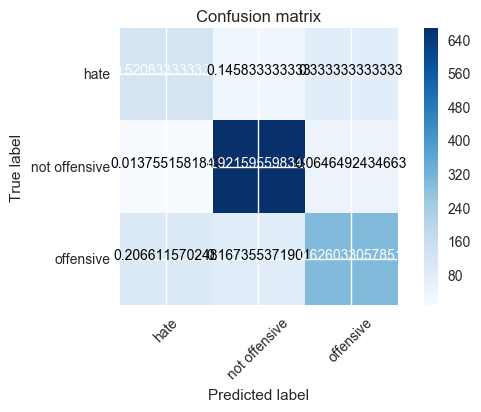

In [102]:
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes, normalize=True)

In [ ]:
fit_log_r.best_estimator_

In [ ]:
param_grid = {'n_estimators':[10, 25, 50, 100]}
forest = RandomForestClassifier(n_jobs=-1)

In [ ]:
fit_forest = test_model(forest, param_grid)

In [ ]:
confusion_matrix(y_test, fit_forest.predict(X_test))

# Dimensionality Reduction

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_features, y_train)
lsvc_select = SelectFromModel(lsvc, prefit=True)
X_train = lsvc_select.transform(train_features)
X_test = lsvc_select.transform(test_features)

In [ ]:
X_test.shape

In [ ]:
log_r = LogisticRegression(class_weight='balanced')
log_r.fit(X_train, y_train)

In [ ]:
preds = log_r.predict(X_test)
print(classification_report(y_test, preds))

# Plots

In [ ]:
text_only_df.sentiment.hist()

In [ ]:
sns.stripplot(x='labels', data=text_only_df, y='sentiment', jitter=True)

In [ ]:
sns.barplot(data=text_only_df, x='labels', y='sentiment')

In [ ]:
text_only_df[(text_only_df['labels']=='hate') & (text_only_df.sentiment > 0.8)].tweet_text.tolist()

In [ ]:
text_only_df.subjectivity.hist()

In [ ]:
sns.stripplot(x='labels', data=text_only_df, y='subjectivity', jitter=True, size=1)

In [ ]:
sns.barplot(data=text_only_df, x='labels', y='subjectivity')

In [ ]:
text_only_df.reading_ease.hist(bins=100)

In [ ]:
text_only_df.reading_grade.hist(bins=100)

In [ ]:
sns.stripplot(data=text_only_df, x='labels', y='reading_ease', jitter=True)

In [ ]:
sns.stripplot(data=text_only_df, x='labels', y='reading_grade', jitter=True)

In [ ]:
sns.pointplot(x='labels', y='reading_ease', data=text_only_df)

In [ ]:
sns.pointplot(x='labels', y='reading_grade', data=text_only_df)